In [1]:
from typing import Literal, Optional, TypeAlias, Union, cast

from IPython.display import Image, display
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores.faiss import FAISS
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_openai import OpenAIEmbeddings
from langchain_tavily import TavilySearch
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [2]:
llm = ChatOllama(model="qwen2.5")

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs_list = [WebBaseLoader(url).load() for url in urls]
docs = [doc for sublist in docs_list for doc in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=20
)
doc_splits = text_splitter.split_documents(docs)

vector_store = FAISS.from_documents(doc_splits, OpenAIEmbeddings())
retriever = vector_store.as_retriever()

In [4]:
system_msg = """
You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keywords(s) or semantic meaning related to the question, grade it as relevant. \n
Give it a binary score 'yes' or 'no'. 'yes' to indicate that the document is relevant to the question, and 'no', 
otherwise.
"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_msg),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [5]:
DocumentGradeT: TypeAlias = Literal["yes", "no"]


class DocumentGrade(BaseModel):
    """Binary score for relevance check on retrieved documents"""

    score: DocumentGradeT = Field(
        description="Documents are relevant to the question, 'yes' or 'no'?"
    )

In [6]:
structured_grade_retriever = llm.with_structured_output(DocumentGrade)
workflow = grade_prompt | structured_grade_retriever
question = "prompt engineering"
docs = retriever.invoke(question)
doc_txt = docs[0].page_content
print(workflow.invoke({"question": question, "document": doc_txt}))

score='yes'


In [7]:
prompt: ChatPromptTemplate = hub.pull("rlm/rag-prompt")


def format_docs(docs: list[Document]) -> str:
    return "\n\n".join(doc.page_content for doc in docs)


rag_workflow = prompt | llm | StrOutputParser()

generation = rag_workflow.invoke({"context": docs, "question": question})
print(generation)

Prompt Engineering, also known as In-Context Prompting, refers to methods for communicating with language models to steer their behavior towards desired outcomes without updating the model weights. It is an empirical science that requires heavy experimentation and heuristics due to varying effects among different models.


In [8]:
system_msg = """
You are a question re-writer that converts an input question into a better version that is optimized \n
for web search. Look at the input and try to reason about the underlying semantic intent / meaning. Answer directly, 
only with the new question, nothing more.
"""

rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_msg),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = rewrite_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is prompt engineering and its applications?'

In [9]:
search_tool = TavilySearch(max_results=3)

In [14]:
class State(BaseModel):
    question: str
    web_search: bool = False
    generated: Optional[str] = None
    documents: Optional[list[Document]] = None

In [15]:
class Retriever:
    def __init__(self, vector_store: FAISS):
        self.vector_store = vector_store
        self.retriever = vector_store.as_retriever()

    def __call__(self, state: State):
        print("------ RETRIEVING DOCUMENTS ------")
        documents = self.retriever.invoke(state.question)
        return {"documents": documents, "question": state.question}


class Generator:
    def __init__(self, llm: ChatOllama, prompt: ChatPromptTemplate):
        self._llm = llm
        self._prompt = prompt
        self._workflow = self._prompt | self._llm | StrOutputParser()

    @property
    def workflow(self):
        return self._workflow

    @workflow.setter
    def workflow(self, workflow):
        self._workflow = workflow

    def __call__(self, state: State) -> dict[str, Union[str, list[Document], None]]:
        print("------ GENERATING ANSWER ------")
        if state.documents is not None:
            generated = self.workflow.invoke(
                {
                    "context": state.documents,
                    "question": state.question,
                }
            )
            return {
                "documents": state.documents,
                "question": state.question,
                "generated": generated,
            }
        else:
            print("No documents to generate from.")
            return {
                "documents": [],
                "question": state.question,
                "generated": None,
            }


class DocumentGrader:
    system_msg = """
    You are an agent responsible for deciding whether a retrieved document should be used to generate a response to a user's question. \n\n
    Evaluate the document for relevance by considering both keywords and semantic meaning in relation to the user's question. \n
    Provide a binary decision: respond with 'yes' if the document should be used, or 'no' if it should not.
    """

    def __init__(self, llm: ChatOllama, output_model: type[DocumentGrade]):
        self._llm = llm.with_structured_output(output_model)
        self._prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_msg),
                (
                    "human",
                    "Retrieved document: \n\n {document} \n\n User question: {question}",
                ),
            ]
        )
        self._workflow = self._prompt | self._llm

    def __call__(self, state: State) -> dict[str, Union[str, list[Document], bool]]:
        print("------ GRADING DOCUMENTS ------")

        if state.documents is not None:

            filtered = self._filter(state.question, state.documents)

            if len(filtered) == 0:

                print("No relevant documents found.")

                state.web_search = True

                return {
                    "documents": [],
                    "question": state.question,
                    "web_search": state.web_search,
                }

            return {
                "documents": state.documents,
                "question": state.question,
                "web_search": state.web_search,
            }
        else:
            print("No documents to grade.")
            return {
                "documents": [],
                "question": state.question,
                "web_search": False,
            }

    def _filter(self, question: str, documents: list[Document]) -> list[Document]:
        """Filter documents based on relevance."""
        filtered: list[Document] = []

        for document in documents:
            grade = self._grade(document, question)
            if grade.score == "yes":
                print(
                    f"Document '{document.metadata.get('source', 'unknown')}' is relevant."
                )
                filtered.append(document)
            else:
                print(
                    f"Document '{document.metadata.get('source', 'unknown')}' is not relevant."
                )

        return filtered

    def _grade(self, document: Document, question: str) -> DocumentGrade:
        """Grade a single document."""
        grade = self._workflow.invoke(
            {"document": document.page_content, "question": question}
        )
        return cast(DocumentGrade, grade)


class QueryTransformer:
    system_msg = """
    You are a question re-writer that converts an input question into a better version that is optimized \n
    for web search. Look at the input and try to reason about the underlying semantic intent / meaning. Answer directly, 
    only with the new question, nothing more.
    """

    def __init__(self, llm: ChatOllama):
        self._prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_msg),
                (
                    "human",
                    "Here is the initial question: \n\n {question} \n Formulate an improved question.",
                ),
            ]
        )
        self._llm = llm
        self._workflow = self._prompt | self._llm | StrOutputParser()

    @property
    def workflow(self):
        return self._workflow

    @workflow.setter
    def workflow(self, workflow):
        self._workflow = workflow

    def __call__(self, state: State) -> dict[str, Union[str, list[Document], None]]:
        print("------ REWRITING QUESTION ------")
        rewritten_question = self._workflow.invoke({"question": state.question})
        print(f"Rewritten question: {rewritten_question}")
        return {"question": rewritten_question, "documents": state.documents}


class WebSearcher:
    def __init__(self, search_tool: TavilySearch):
        self._search_tool = search_tool

    def __call__(self, state: State) -> dict[str, Union[str, list[Document]]]:
        print("------ PERFORMING WEB SEARCH ------")
        search_results = self._search_tool.invoke(state.question)
        documents = [Document(page_content=result) for result in search_results]
        print(f"Found {len(documents)} documents.")
        return {"documents": documents, "question": state.question}


def generation_condition(state: State) -> Literal["transform_query", "generate"]:
    if not state.web_search:
        return "generate"
    return "transform_query"

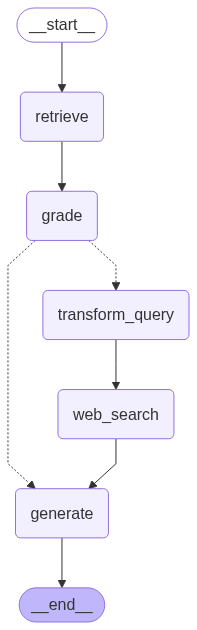

In [16]:
builder = StateGraph(State)
builder.add_node("retrieve", Retriever(vector_store))
builder.add_node("generate", Generator(llm, prompt))
builder.add_node("grade", DocumentGrader(llm, DocumentGrade))
builder.add_node("transform_query", QueryTransformer(llm))
builder.add_node("web_search", WebSearcher(search_tool))

builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "grade")
builder.add_conditional_edges(
    "grade",
    generation_condition,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
builder.add_edge("transform_query", "web_search")
builder.add_edge("web_search", "generate")
builder.add_edge("generate", END)


workflow = builder.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))

In [20]:
workflow.invoke(State(question="What is agent memory?"))

------ RETRIEVING DOCUMENTS ------
------ GRADING DOCUMENTS ------
Document 'https://lilianweng.github.io/posts/2023-06-23-agent/' is relevant.
Document 'https://lilianweng.github.io/posts/2023-06-23-agent/' is not relevant.
Document 'https://lilianweng.github.io/posts/2023-06-23-agent/' is not relevant.
Document 'https://lilianweng.github.io/posts/2023-06-23-agent/' is relevant.
------ GENERATING ANSWER ------


{'question': 'What is agent memory?',
 'web_search': False,
 'generated': 'Agent memory refers to the capability of retaining and recalling information over extended periods. It is often implemented using an external vector store for fast retrieval, enabling the agent to access infinite information that can improve its behavior conditioned on past experiences.',
 'documents': [Document(id='db6a05f5-8f9c-47a9-8c7f-bafff614cd6a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM fun